<a href="https://colab.research.google.com/github/unmo/nlp_for_bert/blob/main/memo/session2/session2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pytorchによる手書き文字分類のサンプル
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

mnist_train = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

print(f"学習データ数: {len(mnist_train)}, 評価データ数: {len(mnist_test)}")

# Dataloderの設定
img_size = 28
batch_size = 256
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

学習データ数: 60000, 評価データ数: 10000


In [ ]:
# モデルの構築
import torch.nn as nn
import torch.nn.functional as F


class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(img_size * img_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forword(self, x):
        x = x.view(-1, img_size * img_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


img_clf = ImageClassifier()
img_clf.cuda()
print(img_clf)


ImageClassifier(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# 学習
from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(img_clf.parameters(), lr=0.01)

record_loss_train = []
record_loss_test = []

epoch = 10

for i in range(epoch):
    img_clf.train()
    loss_train = 0

    # ミニバッチ
    for j, (x, y) in enumerate(train_loader):
        x, y = x.cuda(), y.cuda()
        pred = img_clf.forword(x)
        loss = loss_fn(pred, y)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j + 1
    record_loss_train.append(loss_train)

    img_clf.eval()
    loss_test = 0
    for j, (x, y) in enumerate(test_loader):
        x, y = x.cuda(), y.cuda()
        pred = img_clf.forword(x)
        loss = loss_fn(pred, y)
        # print(f"test j: {j}, loss_item: {loss.item()}")
        loss_test += loss.item()
    loss_test /= j + 1
    record_loss_test.append(loss_test)

    if i % 1 == 0:
        print(f"Epoch: {i}, LossTrain: {loss_train}, LossTest: {loss_test}")



Epoch: 0, LossTrain: 0.08418059746754614, LossTest: 0.13516666151263051
Epoch: 1, LossTrain: 0.07224123150585814, LossTest: 0.12279115666424331
Epoch: 2, LossTrain: 0.05858230988713021, LossTest: 0.11857289741165004
Epoch: 3, LossTrain: 0.05486280333666884, LossTest: 0.13848203927632313
Epoch: 4, LossTrain: 0.054879500100666535, LossTest: 0.12824977635573304
Epoch: 5, LossTrain: 0.06009226676988158, LossTest: 0.12474705930645769
Epoch: 6, LossTrain: 0.048218093107038354, LossTest: 0.13012403363425165
Epoch: 7, LossTrain: 0.05122330085711276, LossTest: 0.17986754451072215
Epoch: 8, LossTrain: 0.0443787661811431, LossTest: 0.13457192052640038
Epoch: 9, LossTrain: 0.03493693632499731, LossTest: 0.13867375970721696


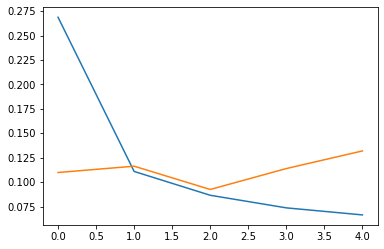

In [ ]:
# 誤差可視化
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")

plt.show()

In [ ]:
correct = 0
total = 0

for i, (x, y) in enumerate(test_loader):
    x, y = x.cuda(), y.cuda()
    x = x.view(-1, img_size*img_size)
    pred = img_clf.forword(x)
    correct += (pred.argmax(1) == y).sum().item()
    total += len(x)

print(f"正解率: {correct/total*100}")


正解率: 97.61999999999999
